In [ ]:
import datetime
import os
import json
from datetime import timezone, date, timedelta
import base64
import operator
from typing import TypedDict, Annotated, List, Optional, Literal
import requests
import uuid
import re


from dotenv import load_dotenv
from pydantic import BaseModel, Field
from tzlocal import get_localzone
import parsedatetime as pdt
from dateutil.parser import parse, ParserError


from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google.auth.exceptions import RefreshError
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText


from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import ToolCall


from IPython.display import Image, display


In [ ]:
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY") 

SCOPES = [
    "https://www.googleapis.com/auth/calendar", 
    "https://www.googleapis.com/auth/gmail.modify",
    "https://www.googleapis.com/auth/tasks"
]

if not all([groq_api_key, tavily_api_key]):
    raise ValueError("One or more required API keys (GROQ, TAVILY) are missing from the .env file!")


# For high-quality, reliable, and rule-following responses (the 70b model).
# Use this for testing complex workflows. 
#llm = ChatGroq(model="llama-3.3-70b-versatile", api_key=groq_api_key, temperature=0)

# For rapid development and simple tests (the 8b model).
# Note: This model is much faster but may not follow complex instructions as precisely.
llm = ChatGroq(model="llama-3.1-8b-instant", api_key=groq_api_key, temperature=0)


print("Groq LLM (Llama) configured and ready.")

In [ ]:
def _get_google_credentials():
    """Gets valid Google API credentials, refreshing if necessary."""

    creds = None

    if os.path.exists("token.json"):
        creds = Credentials.from_authorized_user_file("token.json", SCOPES)

    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file("credentials.json", SCOPES)
            creds = flow.run_local_server(port=0)
        with open("token.json", "w") as token:
            token.write(creds.to_json())

    return creds


def _fetch_google_events(start_date: datetime.datetime, end_date: datetime.datetime) -> List[dict]:
    """Internal function to fetch events from Google Calendar."""

    try:
        creds = _get_google_credentials()
        service = build("calendar", "v3", credentials=creds)
        
        events_result = service.events().list(
            calendarId="primary",
            timeMin=start_date.isoformat(),
            timeMax=end_date.isoformat(),
            maxResults=250,
            singleEvents=True,
            orderBy="startTime"
        ).execute()
        
        return events_result.get("items", [])

    except RefreshError as error:
        print(f"!!! Google Authentication Error: {error}")
        return [{"error_type": "AuthenticationFailed", "details": str(error)}]
    except (requests.exceptions.ConnectionError, ConnectionRefusedError) as error:
        print(f"!!! Network Connection Error: {error}")
        return [{"error_type": "ConnectionFailed", "details": str(error)}]
    except HttpError as error:
        print(f"!!! Google Calendar API HTTP Error: {error}")
        return [{"error_type": "ApiHttpError", "details": str(error)}]
    except Exception as e:
        print(f"!!! An unexpected error occurred in _fetch_google_events: {e}")
        return [{"error_type": "UnknownError", "details": str(e)}]


def _get_email_body(parts):
    """Recursively search for text/plain parts in email body."""

    body = ""
    if parts:
        for part in parts:
            if part['mimeType'] == 'text/plain' and 'data' in part['body']:
                body += base64.urlsafe_b64decode(part['body']['data']).decode('utf-8')
            elif 'parts' in part:
                body += _get_email_body(part['parts'])

    return body


def _fetch_gmail_messages(query: str, max_results: int = 10) -> List[dict]:
    """Internal function to fetch and sort emails from Gmail using batch processing."""
    
    try:
        creds = _get_google_credentials()
        service = build("gmail", "v1", credentials=creds)

        message_list = service.users().messages().list(userId='me', q=query, maxResults=max_results).execute()
        messages = message_list.get('messages', [])
        
        if not messages: return []

        output_emails = []

        def gmail_callback(request_id, response, exception):
            if exception is None:
                headers = response['payload']['headers']
                output_emails.append({
                    "id": response['id'],
                    "sender": next((h['value'] for h in headers if h['name'] == 'From'), 'Unknown Sender'),
                    "subject": next((h['value'] for h in headers if h['name'] == 'Subject'), 'No Subject'),
                    "date": next((h['value'] for h in headers if h['name'] == 'Date'), 'Unknown Date'),
                    "body": _get_email_body(response['payload'].get('parts', []))[:2000],
                    "internalDate": response['internalDate']
                })

        batch_request = service.new_batch_http_request(callback=gmail_callback)
        for msg in messages:
            batch_request.add(service.users().messages().get(userId='me', id=msg['id'], format='full'))
        
        batch_request.execute()
        output_emails.sort(key=lambda e: int(e['internalDate']), reverse=True)
        return output_emails

    except RefreshError as error:
        print(f"!!! Google Authentication Error: {error}")
        return [{"error_type": "AuthenticationFailed", "details": str(error)}]
    except (requests.exceptions.ConnectionError, ConnectionRefusedError) as error:
        print(f"!!! Network Connection Error: {error}")
        return [{"error_type": "ConnectionFailed", "details": str(error)}]
    except HttpError as error:
        print(f"!!! Gmail API HTTP Error: {error}")
        return [{"error_type": "ApiHttpError", "details": str(error)}]
    except Exception as e:
        print(f"!!! An unexpected error occurred in _fetch_gmail_messages: {e}")
        return [{"error_type": "UnknownError", "details": str(e)}]



In [ ]:
def _parse_natural_language_time(natural_language_time: str) -> datetime.datetime | None:
    """
    Parses a natural language date and time string into a timezone-aware datetime object.
    This is our single, robust helper for all date/time parsing needs.
    """

    try:
        cal = pdt.Calendar()
        time_struct, parse_status = cal.parse(natural_language_time)

        if parse_status != 0:
            dt_object = datetime.datetime(*time_struct[:6])

            return dt_object.replace(tzinfo=get_localzone())
        return None

    except Exception as e:
        print(f"!!! Error in _parse_natural_language_time: {e}")
        return None


In [ ]:
@tool
def list_upcoming_events(limit: Optional[int] = 15) -> str:
    """Lists the user's upcoming Google Calendar events from today onwards."""

    print(f"--- Tool: list_upcoming_events called with limit={limit} ---")

    now = datetime.datetime.now(timezone.utc)
    search_end = now + datetime.timedelta(days=90)

    google_events = _fetch_google_events(start_date=now, end_date=search_end)

    if not google_events:
        return json.dumps([])

    valid_events = [e for e in google_events if 'error_type' not in e]

    return json.dumps(valid_events[:limit], indent=2)


@tool
def get_events_for_day(natural_language_date: str) -> str:
    """Finds and lists all Google Calendar events for a specific day (like 'tomorrow', 'this Sunday')."""

    dt_obj = _parse_natural_language_time(natural_language_date)

    if not dt_obj:
        return json.dumps([{"error": f"I could not understand the date: '{natural_language_date}'"}])

    target_date = dt_obj.date()
    
    print(f"--- Tool: get_events_for_day called for '{natural_language_date}' -> Resolved to: {target_date.isoformat()} ---")

    try:
        start_of_day = datetime.datetime.combine(target_date, datetime.time.min).replace(tzinfo=get_localzone())
        end_of_day = datetime.datetime.combine(target_date, datetime.time.max).replace(tzinfo=get_localzone())

        google_events = _fetch_google_events(start_date=start_of_day.astimezone(timezone.utc), end_date=end_of_day.astimezone(timezone.utc))
        valid_events = [e for e in google_events if 'error' not in e]

        if not valid_events:
            return json.dumps([])
        return json.dumps(valid_events, indent=2)

    except Exception as e:
        return json.dumps([{"error": f"An unexpected error occurred: {e}"}])

@tool
def tavily_search(query: str) -> str:
    """A search engine tool to find real-time information online."""

    print(f"--- Tool: tavily_search called with query: '{query}' ---")

    try:
        search = TavilySearch(max_results=3, api_key=tavily_api_key)
        results = search.invoke(query)
        return json.dumps(results, indent=2)

    except requests.exceptions.ConnectionError as e:
        print(f"!!! Tavily Connection Error: {e}")
        return json.dumps([{"error_type": "ConnectionFailed", "details": str(e)}])
    except Exception as e:
        print(f"!!! Tavily Unexpected Error: {e}")
        return json.dumps([{"error_type": "UnknownError", "details": str(e)}])
    


@tool
def create_google_event(
    summary: str, 
    start_time_natural: str, 
    duration_minutes: int,
    description: Optional[str] = None, 
    location: Optional[str] = None, 
    attendees: Optional[List[str]] = None
) -> str:
    """
    Creates a new event on Google Calendar using natural language for the start time after checking for conflicts.

    Args:
        summary (str): The title or summary of the event.
        start_time_natural (str): The start time in natural language (e.g., "tomorrow at 4 PM", "next Tuesday at 11am").
        duration_minutes (int): The duration of the event in minutes.
        description (Optional[str]): A detailed description for the event.
        location (Optional[str]): The physical location of the event.
        attendees (Optional[List[str]]): A list of attendee email addresses to invite.
    """

    print(f"--- Tool: create_google_event received natural language query: '{start_time_natural}' ---")

    start_time_obj = _parse_natural_language_time(start_time_natural)

    if not start_time_obj:
        return f"Error: I could not understand the start time '{start_time_natural}'."

    end_time_obj = start_time_obj + datetime.timedelta(minutes=duration_minutes)
    
    try:
        conflicting_events = _fetch_google_events(start_date=start_time_obj, end_date=end_time_obj)

        if conflicting_events:
            conflict_summary = conflicting_events[0].get('summary', 'an existing event')
            return f"Error: Cannot create event. There is a conflicting event at that time: '{conflict_summary}'."

        start_time_iso = start_time_obj.isoformat()
        end_time_iso = end_time_obj.isoformat()

        print(f"--- Finalizing API Call with: summary='{summary}', start='{start_time_iso}', end='{end_time_iso}', description='{description}', location='{location}', attendees='{attendees}' ---")

        creds = _get_google_credentials()
        service = build("calendar", "v3", credentials=creds)
        
        local_timezone = str(get_localzone())
        
        event_body = {
            'summary': summary,
            'start': {'dateTime': start_time_iso, 'timeZone': str(get_localzone())},
            'end': {'dateTime': end_time_iso, 'timeZone': str(get_localzone())},
        }

        if description:
            event_body['description'] = description
        
        if location:
            event_body['location'] = location
        
        if attendees:
            event_body['attendees'] = [{'email': email} for email in attendees]

        created_event = service.events().insert(calendarId='primary', body=event_body).execute()
        
        print(f"--- Success: Event created. ID: {created_event.get('id')} ---")
        return f"Success! Event '{summary}' was created for {start_time_obj.strftime('%Y-%m-%d %H:%M')}."

    except Exception as e:
        print(f"!!! Google Calendar Write Error: {e}")
        return f"An error occurred while creating the event in Google Calendar: {e}"



@tool
def delete_google_event(event_id: str, summary: str) -> str:
    """Deletes an event from the calendar using its unique ID."""

    print(f"--- Tool: delete_google_event called for ID: {event_id} ---")

    try:
        creds = _get_google_credentials()
        service = build("calendar", "v3", credentials=creds)
        service.events().delete(calendarId='primary', eventId=event_id).execute()

        return f"The event '{summary}' was successfully deleted."

    except Exception as e:
        return f"An error occurred while deleting the event: {e}"

@tool
def get_events_for_range(time_range: str) -> str:
    """
    Fetches all Google Calendar events for a specific range like "this week", "next week", or "this month".
    Use this for broader queries about a period of time, not a single day.
    Supported ranges: "this week", "next week", "this month".

    """
    print(f"--- Tool: get_events_for_range called for: {time_range} ---")

    today = datetime.date.today()
    start_date, end_date = None, None

    if time_range == "this week":
        start_date = today - datetime.timedelta(days=today.weekday())
        end_date = start_date + datetime.timedelta(days=6)
    elif time_range == "next week":
        start_date = today + datetime.timedelta(days=(7 - today.weekday()))
        end_date = start_date + datetime.timedelta(days=6)
    elif time_range == "this month":
        start_date = today.replace(day=1)
        next_month = start_date.replace(day=28) + datetime.timedelta(days=4)
        end_date = next_month - datetime.timedelta(days=next_month.day)
    else:
        return json.dumps([{"error": "Unsupported time range. Please use 'this week', 'next week', or 'this month'."}])

    print(f"--- Calculated Date Range: {start_date.isoformat()} to {end_date.isoformat()} ---")
    
    start_datetime = datetime.datetime.combine(start_date, datetime.time.min).astimezone(timezone.utc)
    end_datetime = datetime.datetime.combine(end_date, datetime.time.max).astimezone(timezone.utc)
    events = _fetch_google_events(start_date=start_datetime, end_date=end_datetime)

    return json.dumps(events, indent=2)

@tool
def update_google_event(
    event_id: str,
    new_summary: Optional[str] = None,
    new_start_time_natural: Optional[str] = None,
    new_duration_minutes: Optional[int] = None,
    new_description: Optional[str] = None,
    new_location: Optional[str] = None,
    new_attendees: Optional[List[str]] = None
    ) -> str:
    """
    Updates an existing Google Calendar event using its unique ID. 
    Accepts natural language for the new start time.
    If only a new start time is provided, the original duration is maintained
    """

    print(f"--- Tool: update_google_event called for ID: {event_id} ---")

    try:
        creds = _get_google_credentials()
        service = build("calendar", "v3", credentials=creds)

        event = service.events().get(calendarId='primary', eventId=event_id).execute()

        update_body = {}

        if new_summary:
            update_body['summary'] = new_summary

        if new_description:
            update_body['description'] = new_description
            
        if new_location:
            update_body['location'] = new_location
            
        if new_attendees is not None:
            update_body['attendees'] = [{'email': email} for email in new_attendees]

        if new_start_time_natural:
            new_start_obj = _parse_natural_language_time(new_start_time_natural)
            if not new_start_obj:
                return f"Error: I could not understand the new start time '{new_start_time_natural}'."
            
            if new_duration_minutes:
                new_end_obj = new_start_obj + datetime.timedelta(minutes=new_duration_minutes)
            else:
                original_start = parse(event['start'].get('dateTime'))
                original_end = parse(event['end'].get('dateTime'))
                original_duration = original_end - original_start
                new_end_obj = new_start_obj + original_duration

            update_body['start'] = {'dateTime': new_start_obj.isoformat(), 'timeZone': str(get_localzone())}
            update_body['end'] = {'dateTime': new_end_obj.isoformat(), 'timeZone': str(get_localzone())}
        
        if not update_body:
            return "Error: No update information was provided for the event."

        updated_event = service.events().patch(
            calendarId='primary', 
            eventId=event_id, 
            body=update_body
        ).execute()

        return f"Success! Event '{updated_event.get('summary')}' was updated."

    except HttpError as err:
        if err.resp.status == 404:
            return f"Error: The event with ID '{event_id}' was not found."
        return f"An API error occurred: {err}"
    except Exception as e:
        return f"An unexpected error occurred while updating the event: {e}"


In [ ]:

@tool
def search_emails(
    sender: Optional[str] = None, 
    subject: Optional[str] = None, 
    keywords: Optional[str] = None, 
    status: Optional[str] = "all", 
    time_range: Optional[str] = None, 
    max_results: int = 10
) -> str:
    """
    Searches for emails in the user's Gmail account based on various criteria.
    Returns the raw email data as a structured JSON string for the agent to process.
    """

    print(f"--- Tool: search_emails called with filters: status='{status}', sender='{sender}', subject='{subject}', keywords='{keywords}', time_range='{time_range}' ---")

    query_parts = []
    if status == "unread":
        query_parts.append("is:unread")
    elif status == "read":
        query_parts.append("is:read")
    if sender:
        query_parts.append(f"from:{sender}")
    if subject:
        query_parts.append(f"subject:({subject})")
    if keywords:
        query_parts.append(keywords)
    if time_range:
        query_parts.append(f"newer_than:{time_range}")

    query = " ".join(query_parts)

    emails = _fetch_gmail_messages(query=query, max_results=max_results)
    
    if not emails or all('error' in e for e in emails):
        return json.dumps([]) 

    return json.dumps(emails, indent=2)


@tool
def delete_email(message_id: str) -> str:
    """
    Moves a specific email to the trash using its unique message ID.
    To use this tool, you must first find the email and its 'id' using the `search_emails` tool.
    """
    print(f"--- Tool: delete_email called for message ID: {message_id} ---")
    try:
        creds = _get_google_credentials()
        service = build("gmail", "v1", credentials=creds)
        
        service.users().messages().trash(userId='me', id=message_id).execute()
        
        return "Success: The email was moved to the trash."
        
    except HttpError as error:
        if error.resp.status == 404:
            return f"Error: The email with ID '{message_id}' was not found."
        return f"An error occurred with the Gmail API: {error}"
    except Exception as e:
        return f"An unexpected error occurred while trying to delete the email: {e}"


@tool
def archive_email(message_id: str) -> str:
    """
    Archives a specific email by removing it from the inbox, using its unique message ID.
    To use this tool, you must first find the email and its 'id' using the `search_emails` tool.
    """
    print(f"--- Tool: archive_email called for message ID: {message_id} ---")
    try:
        creds = _get_google_credentials()
        service = build("gmail", "v1", credentials=creds)
        
        modify_request = {
            'removeLabelIds': ['INBOX']
        }
        
        service.users().messages().modify(
            userId='me', 
            id=message_id, 
            body=modify_request
        ).execute()
        
        return "Success: The email was archived and removed from the inbox."
        
    except HttpError as error:
        if error.resp.status == 404:
            return f"Error: The email with ID '{message_id}' was not found."
        return f"An error occurred with the Gmail API: {error}"
    except Exception as e:
        return f"An unexpected error occurred while trying to archive the email: {e}"



@tool
def create_email_draft(to: str, subject: str, body: str) -> str:
    """
    Creates a draft of an email and returns its draft ID.
    """
    print(f"--- Tool: create_email_draft called for recipient: '{to}' ---")
    try:
        creds = _get_google_credentials()
        service = build("gmail", "v1", credentials=creds)

        message = MIMEMultipart()
        message['to'] = to
        message['subject'] = subject
        
        msg = MIMEText(body)
        message.attach(msg)

        raw_message = base64.urlsafe_b64encode(message.as_bytes()).decode()
        draft_body = {'message': {'raw': raw_message}}

        draft = service.users().drafts().create(userId='me', body=draft_body).execute()

        response = {
            "status": "Success",
            "draft_id": draft['id'],
            "message": f"A draft email to '{to}' was created. Please review it in Gmail."
        }

        return json.dumps(response)
        
    except Exception as e:
        print(f"!!! An error occurred in create_email_draft: {e}")
        return json.dumps([{"error_type": "UnknownError", "details": str(e)}])



@tool
def send_draft(draft_id: str) -> str:
    """
    Sends a specific email draft using its unique draft ID.
    """
    print(f"--- Tool: send_draft called for draft ID: {draft_id} ---")
    try:
        creds = _get_google_credentials()
        service = build("gmail", "v1", credentials=creds)
        
        service.users().drafts().send(userId='me', body={'id': draft_id}).execute()
        
        return "Success: The draft was sent."
        
    except HttpError as error:
        return f"An error occurred with the Gmail API: {error}"
    except Exception as e:
        return f"An unexpected error occurred: {e}"



@tool
def create_reply_draft(original_message_id: str, body: str) -> str:
    """
    Creates a DRAFT of a reply to a specific email, it does NOT send it.  

    Args:
        original_message_id (str): The unique ID of the email to reply to.
        body (str): The main text content of the reply email that the agent composes.
    """
    print(f"--- Tool: create_reply_draft called for message ID: {original_message_id} ---")
    try:
        creds = _get_google_credentials()
        service = build("gmail", "v1", credentials=creds)

        original_message = service.users().messages().get(userId='me', id=original_message_id).execute()
        original_headers = original_message['payload']['headers']
        
        original_subject = next(h['value'] for h in original_headers if h['name'].lower() == 'subject')
        original_from = next(h['value'] for h in original_headers if h['name'].lower() == 'from')
        original_message_id_header = next(h['value'] for h in original_headers if h['name'].lower() == 'message-id')

        reply_message = MIMEMultipart()
        reply_subject = original_subject if original_subject.lower().startswith('re:') else f"Re: {original_subject}"
        reply_message['to'] = original_from
        reply_message['subject'] = reply_subject
        reply_message['In-Reply-To'] = original_message_id_header
        reply_message['References'] = original_message_id_header
        
        reply_message.attach(MIMEText(body))
        
        raw_message = base64.urlsafe_b64encode(reply_message.as_bytes()).decode()
        draft_body = {'message': {'raw': raw_message, 'threadId': original_message['threadId']}}
        
        draft = service.users().drafts().create(userId='me', body=draft_body).execute()
        
        response = {
            "status": "Success",
            "draft_id": draft['id'],
            "message": f"A draft reply to '{original_from}' was created. Please review it in Gmail."
        }
        return json.dumps(response)

    except Exception as e:
        print(f"!!! An error occurred in reply_to_email: {e}")
        return json.dumps({"error_type": "UnknownError", "details": str(e)})

In [ ]:
@tool
def list_tasks(task_list_name: str = "@default") -> str:
    """
    Lists all incomplete tasks from a specific Google Tasks list.
    If no list name is provided, it uses the user's primary/default task list.
    """
    print(f"--- Tool: list_tasks called for list: '{task_list_name}' ---")
    try:
        creds = _get_google_credentials()
        service = build("tasks", "v1", credentials=creds)

        task_lists_result = service.tasklists().list().execute()
        task_lists = task_lists_result.get("items", [])
        
        target_list_id = None
        if task_list_name == "@default" and task_lists:
            target_list_id = task_lists[0]['id'] 
        else:
            for lst in task_lists:
                if lst['title'].lower() == task_list_name.lower():
                    target_list_id = lst['id']
                    break
        
        if not target_list_id:
            return f"Error: Task list '{task_list_name}' not found."

        tasks_result = service.tasks().list(
            tasklist=target_list_id, 
            showCompleted=False 
        ).execute()
        
        tasks = tasks_result.get("items", [])
        return json.dumps(tasks, indent=2)

    except Exception as e:
        print(f"!!! An error occurred in list_tasks: {e}")
        return json.dumps([{"error_type": "UnknownError", "details": str(e)}])



@tool
def add_task(
    title: str,
    task_list_name: str = "@default",
    due_date_natural: Optional[str] = None
    ) -> str:
    """
    Adds a new task to a specific Google Tasks list, optionally with a due date.

    Args:
        title (str): The title of the task.
        task_list_name (str): The name of the task list. Defaults to the primary list.
        due_date_natural (Optional[str]): The due date in natural language (e.g., "tomorrow", "next Monday").
    """
    print(f"--- Tool: add_task called with title: '{title}', due_date: '{due_date_natural}' ---")

    try:
        creds = _get_google_credentials()
        service = build("tasks", "v1", credentials=creds)

        task_lists_result = service.tasklists().list().execute()
        task_lists = task_lists_result.get("items", [])
        
        target_list_id = None
        if task_list_name == "@default" and task_lists:
            target_list_id = task_lists[0]['id']
        else:
            for lst in task_lists:
                if lst['title'].lower() == task_list_name.lower():
                    target_list_id = lst['id']
                    break
        
        if not target_list_id:
            return f"Error: Task list '{task_list_name}' not found."

        task_body = {'title': title}

        if due_date_natural:
            due_time_obj = _parse_natural_language_time(due_date_natural)
            if due_time_obj:
                task_body['due'] = due_time_obj.astimezone(timezone.utc).isoformat()
            else:
                return f"Error: I could not understand the due date '{due_date_natural}'."

        created_task = service.tasks().insert(
            tasklist=target_list_id, 
            body=task_body
        ).execute()
        
        return f"Success: The task '{created_task.get('title')}' was added."

    except Exception as e:
        print(f"!!! An error occurred in add_task: {e}")
        return json.dumps([{"error_type": "UnknownError", "details": str(e)}])



@tool
def complete_task(task_id: str, task_list_id: str = "@default_id_placeholder") -> str:
    """
    Marks a specific task as completed using its unique ID.
    To use this tool, you must first find the task and its 'id' using the `list_tasks` tool.
    The task_list_id is usually found alongside the task_id from the list_tasks tool.
    """
    print(f"--- Tool: complete_task called for task ID: {task_id} ---")
    try:
        creds = _get_google_credentials()
        service = build("tasks", "v1", credentials=creds)

        task = service.tasks().get(tasklist=task_list_id, task=task_id).execute()
        
        task['status'] = 'completed'
        
        completed_task = service.tasks().update(
            tasklist=task_list_id,
            task=task_id,
            body=task
        ).execute()
        
        return f"Success: The task '{completed_task.get('title')}' was marked as completed."

    except HttpError as error:
        if error.resp.status == 404:
            return f"Error: The task with ID '{task_id}' was not found in the specified list."
        return json.dumps([{"error_type": "ApiHttpError", "details": str(error)}])
    except Exception as e:
        print(f"!!! An error occurred in complete_task: {e}")
        return json.dumps([{"error_type": "UnknownError", "details": str(e)}])


@tool
def update_task(
    task_id: str,
    task_list_id: str = "@default_id_placeholder",
    new_title: Optional[str] = None,
    new_due_date_natural: Optional[str] = None
) -> str:
    """
    Updates an existing task's title or due date using its unique ID.
    To use this tool, first find the task and its 'id' and 'task_list_id'.
    """
    print(f"--- Tool: update_task called for task ID: {task_id} ---")
    
    update_body = {}
    if new_title:
        update_body['title'] = new_title
        
    if new_due_date_natural:
        due_time_obj = _parse_natural_language_time(new_due_date_natural)
        if due_time_obj:
            due_date = due_time_obj.date()
            due_datetime_utc = datetime.datetime.combine(due_date, datetime.time.min).astimezone(timezone.utc)
            update_body['due'] = due_datetime_utc.isoformat().replace('+00:00', 'Z')
        else:
            return f"Error: I could not understand the new due date '{new_due_date_natural}'."

    if not update_body:
        return "Error: No new information (title or due date) was provided to update the task."

    try:
        creds = _get_google_credentials()
        service = build("tasks", "v1", credentials=creds)
        
        updated_task = service.tasks().patch(
            tasklist=task_list_id,
            task=task_id,
            body=update_body
        ).execute()
        
        return f"Success: The task was updated to '{updated_task.get('title')}'."

    except HttpError as error:
        if error.resp.status == 404:
            return f"Error: The task with ID '{task_id}' was not found in the specified list."
        return json.dumps([{"error_type": "ApiHttpError", "details": str(error)}])
    except Exception as e:
        print(f"!!! An error occurred in update_task: {e}")
        return json.dumps([{"error_type": "UnknownError", "details": str(e)}])



@tool
def delete_task(task_id: str, task_list_id: str = "@default_id_placeholder") -> str:
    """
    Deletes a specific task using its unique ID.
    To use this tool, you must first find the task and its 'id' and 'task_list_id'.
    This is a permanent action, so user confirmation is required.
    """
    print(f"--- Tool: delete_task called for task ID: {task_id} ---")
    try:
        creds = _get_google_credentials()
        service = build("tasks", "v1", credentials=creds)

        service.tasks().delete(
            tasklist=task_list_id,
            task=task_id
        ).execute()
        
        return "Success: The task was permanently deleted."

    except HttpError as error:
        if error.resp.status == 404:
            return f"Error: The task with ID '{task_id}' was not found in the specified list."
        return json.dumps([{"error_type": "ApiHttpError", "details": str(error)}])
    except Exception as e:
        print(f"!!! An error occurred in delete_task: {e}")
        return json.dumps([{"error_type": "UnknownError", "details": str(e)}])

In [ ]:
calendar_tools = [
    list_upcoming_events,
    get_events_for_day,
    create_google_event,
    delete_google_event,
    get_events_for_range,
    update_google_event]

email_tools = [
    search_emails,
    delete_email,
    archive_email,
    create_email_draft,
    send_draft,
    create_reply_draft]

search_tools = [tavily_search]

task_tools = [list_tasks, add_task, complete_task, update_task, delete_task]


print(f"Defined {len(calendar_tools)} tools for the Calendar Expert.")
print(f"Defined {len(email_tools)} tools for the Email Expert.")
print(f"Defined {len(search_tools)} tools for the Search Expert.")
print(f"Defined {len(task_tools)} tools for the Task Expert.")

In [ ]:
class AgentState(TypedDict):
    messages: Annotated[list, operator.add]
    route: Literal["calendar", "email", "search", "conversational"]
    error: str


class RouteQuery(BaseModel):
    """Route the user's query to the correct expert."""

    route: Literal["calendar", "email", "search", "tasks", "conversational"] = Field(
        description="""The category to route the user's request to, based on their intent.
        - 'calendar': For managing calendar events.
        - 'email': For managing emails.
        - 'search': For general knowledge questions.
        - 'tasks': For managing to-do lists and tasks (e.g., "add a to-do", "list my tasks").
        - 'conversational': For simple chit-chat."""
    )


def router_node(state: AgentState):
    """
    Analyzes the user's latest message AND the assistant's last message
    to route the task to the appropriate expert, especially for multi-step tasks.
    """
    print("--- Smart Router Node ---")
    
    structured_llm_router = llm.with_structured_output(RouteQuery)
    
    messages = state['messages']
    user_message = messages[-1].content
    
    last_ai_message_content = ""
    if len(messages) > 1 and isinstance(messages[-2], AIMessage):
        last_ai_message_content = messages[-2].content

    router_prompt_template = f"""You are an expert task router. Your job is to classify the user's latest message based on the conversation history.

    Here is the context of the last turn:
    Assistant's previous message: "{last_ai_message_content}"
    User's latest message: "{user_message}"

    **CRITICAL RULE:** If the assistant's previous message was a confirmation question (e.g., "Are you sure you want to delete...?"), and the user's message is a confirmation (e.g., "yes", "confirm", "please do"), you MUST route this to the original task's category (e.g., 'calendar'). Do not classify it as 'conversational'.

    Otherwise, classify the user's latest message based on its content.
    """
    
    route_decision = structured_llm_router.invoke(router_prompt_template)
    
    print(f"Smart Router Decision: '{route_decision.route}'")
    return {"route": route_decision.route}



today_str = datetime.date.today().isoformat()
today_day_name = datetime.date.today().strftime('%A')

GENERAL_RULES = """
**General Rules:**
- After a tool runs, you MUST summarize the result in a friendly, natural sentence. Do not show raw data.
- If a tool returns an empty list `[]`, inform the user in a helpful way (e.g., "It looks like you have no events.").
- When an action is successful, confirm it reassuringly (e.g., "All set! I've added that to your list.").
"""


calendar_system_prompt = f"""You are a Google Calendar expert. Today is {today_str} ({today_day_name}).

Your instructions are:
- To answer the user's request, you must use one of the provided tools.
- For a specific day (e.g., "tomorrow", "Sep 15"), use the `get_events_for_day` tool.
- For a date range (e.g., "this week"), use the `get_events_for_range` tool.
- For general future queries (e.g., "what's next?"), use `list_upcoming_events`.
- **If the user asks for a specific NUMBER of events (e.g., "next 5 events"), you MUST use the `list_upcoming_events` tool with the `limit` parameter. Do not interpret this as a time range.**
- Before using `delete_google_event` or `update_google_event`, you must first find the event's ID and ask the user for confirmation.
- After a tool runs, summarize the result in a friendly, natural sentence. Do not show raw data like JSON.
- If a tool returns an empty list `[]`, inform the user in a helpful way, for example, "It looks like you have no upcoming events."

{GENERAL_RULES}
"""


email_system_prompt = f"""You are an expert at managing a Gmail account.

Your instructions are:
- To answer the user's request, you must use one of the provided tools.
- For searching emails, use the `search_emails` tool with appropriate filters.
- Before using `delete_email`, you MUST get the email's ID and ask the user for confirmation.
- To send an email or reply, you MUST first use a draft tool (`create_email_draft` or `create_reply_draft`). Only use `send_draft` after the user confirms the draft.
- After a tool runs, summarize the result in a friendly, natural sentence.

{GENERAL_RULES}
"""


search_system_prompt = f"""You are an expert researcher. Your only function is to answer questions using the `tavily_search` tool.

CRITICAL RULES:
- You are FORBIDDEN from answering from your memory. You MUST use the `tavily_search` tool for every factual query.
- Do not show raw JSON output. You must read the `content` of the search results, synthesize the information, and provide a single, coherent answer.
- If the tool finds nothing, state that you could not find any information online.

{GENERAL_RULES}
"""


tasks_system_prompt = f"""You are an expert at managing a Google Tasks to-do list.

Your instructions are:
- To answer the user's request, you must use one of the provided tools.
- To complete, update, or delete a task, you must first find its `id` and `task_list_id` (use `list_tasks` if the context is unclear).
- Before using `delete_task`, you MUST ask the user for confirmation as it is a permanent action.
- After a tool runs, summarize the result in a friendly, natural sentence.

{GENERAL_RULES}
"""

In [ ]:
llm_with_calendar_tools = llm.bind_tools(calendar_tools)
calendar_tool_node = ToolNode(calendar_tools)


def calendar_agent_node(state: AgentState):
    print("--- Calendar Expert Node ---")
    messages = [SystemMessage(content=calendar_system_prompt)] + state['messages']
    response = llm_with_calendar_tools.invoke(messages)
    return {"messages": [response]}

llm_with_email_tools = llm.bind_tools(email_tools)
email_tool_node = ToolNode(email_tools)


def email_agent_node(state: AgentState):
    print("--- Email Expert Node ---")
    messages = [SystemMessage(content=email_system_prompt)] + state['messages']
    response = llm_with_email_tools.invoke(messages)
    return {"messages": [response]}

llm_with_search_tools = llm.bind_tools(search_tools)
search_tool_node = ToolNode(search_tools)



def search_agent_node(state: AgentState):
    print("--- Search Expert Node ---")
    messages = [SystemMessage(content=search_system_prompt)] + state['messages']
    response = llm_with_search_tools.invoke(messages)
    return {"messages": [response]}


    
llm_with_task_tools = llm.bind_tools(task_tools)
task_tool_node = ToolNode(task_tools)


def task_agent_node(state: AgentState):
    print("--- Task Expert Node ---")
    messages = [SystemMessage(content=tasks_system_prompt)] + state['messages']
    response = llm_with_task_tools.invoke(messages)
    return {"messages": [response]}


def conversational_node(state: AgentState):

    print("--- Conversational Node ---")
    response = llm.invoke(state['messages'])
    return {"messages": [response]}


In [ ]:
def should_call_tools(state: AgentState) -> Literal["tools", END]:
    """
    Checks if the last message is an AIMessage with tool calls.
    """
    if not state['messages']:
        return END

    last_message = state['messages'][-1]
    
    if isinstance(last_message, AIMessage):
        if last_message.tool_calls:
            return "tools"
        else:
            return END
    else:
        return END

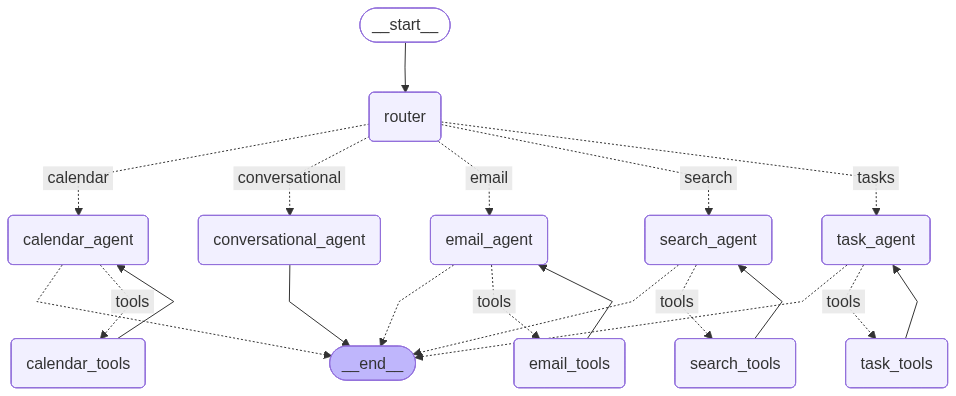

In [277]:
workflow = StateGraph(AgentState)

workflow.add_node("router", router_node)
workflow.add_node("calendar_agent", calendar_agent_node)
workflow.add_node("calendar_tools", calendar_tool_node)
workflow.add_node("email_agent", email_agent_node)
workflow.add_node("email_tools", email_tool_node)
workflow.add_node("search_agent", search_agent_node)
workflow.add_node("search_tools", search_tool_node)
workflow.add_node("conversational_agent", conversational_node)
workflow.add_node("task_agent", task_agent_node)
workflow.add_node("task_tools", task_tool_node)

workflow.set_entry_point("router")

workflow.add_conditional_edges(
    "router",
    lambda state: state["route"],
    {
        "calendar": "calendar_agent",
        "email": "email_agent",
        "search": "search_agent",
        "tasks": "task_agent",
        "conversational": "conversational_agent"
    }
)

workflow.add_edge("conversational_agent", END)


workflow.add_conditional_edges("calendar_agent", should_call_tools, {"tools": "calendar_tools", END: END})
workflow.add_edge("calendar_tools", "calendar_agent")

workflow.add_conditional_edges("email_agent", should_call_tools, {"tools": "email_tools", END: END})
workflow.add_edge("email_tools", "email_agent")

workflow.add_conditional_edges("task_agent", should_call_tools, {"tools": "task_tools", END: END})
workflow.add_edge("task_tools", "task_agent")

workflow.add_conditional_edges("search_agent", should_call_tools, {"tools": "search_tools", END: END})
workflow.add_edge("search_tools", "search_agent")

display(Image(app.get_graph().draw_mermaid_png()))


In [ ]:
db_path = os.path.abspath("conversations.sqlite")

print(f"Using database at: {db_path}")

with SqliteSaver.from_conn_string(db_path) as memory:
    
    app = workflow.compile(checkpointer=memory)
    print("\nRouter-based graph compiled. Ready for interaction.")
    
    config = {"configurable": {"thread_id": "berky_alkn74"}}
    print("\nYour persistent assistant is ready. You can now start chatting.")
    print("Type 'quit' or 'exit' to end the conversation.")
    print("-" * 50)
    
    while True:
        try:
            user_input = input("You: ")
            if user_input.lower() in ["quit", "exit"]:
                print("Assistant: Goodbye!")
                break

            print(f"You: {user_input}")
            
            messages = [HumanMessage(content=user_input)]
            
            response = app.invoke({"messages": messages}, config)
            
            final_response = response["messages"][-1]
            if final_response.content:
                 print(f"Assistant: {final_response.content}")
            
        except Exception as e:
            print(f"\n--- An Error Occurred ---")
            print(f"Error: {e}")
            print("Please try again.")
